In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

Usually these candidates are found using the dark matter information. 
In this notebook we take a different approach by selecting them based on the baryonic information.

Our candidates are thus pairs selected based on the stellar masses.

1. They are composed by two galaxies $G_A$ and $G_B$.
2. $G_A$ and $G_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all subhalos with stellar mass content  $1.0\times 10^{10}$ M$_{\odot}<M_s < 1.0\times 10^{11}$ M$_{\odot}$ (http://adsabs.harvard.edu//abs/2013AAS...22125411L, http://arxiv.org/abs/1410.0017)
3. The distance between $H_A$ and $H_B$ is less than 1500 kpc and larger than 500 kpc.
4. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
5. Within 1800 kpc there are not any subhalos with stellar masses larger than the lower stellar mass galaxy in the pair.

We now proceed to build such sample.

In [3]:
%pylab inline
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [4]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"
hubble = 0.704

In [5]:
#halos = gc.loadHalos(basePath,135)
#subhalos = gc.loadSubhalos(basePath,135)
#header = gc.loadHeader(basePath,135)
#BoxSize = header['BoxSize']

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,135, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,135, fields=subhalo_fields)
header = gc.loadHeader(basePath,135)
BoxSize = header['BoxSize']

In [6]:
print(halos.keys())
print(subhalos.keys())

dict_keys(['Group_R_Crit200', 'GroupMassType', 'count', 'Group_M_Mean200', 'GroupFirstSub', 'GroupVel', 'Group_M_Crit200', 'GroupPos', 'GroupNsubs'])
dict_keys(['SubhaloGrNr', 'SubhaloParent', 'SubhaloVel', 'count', 'SubhaloMass', 'SubhaloStellarPhotometrics', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFRinRad', 'SubhaloVmax'])


In [7]:
#mases are: Gas, DM, unused, tracers, stars+wind particles, black holes
halo_masses = halos['GroupMassType']
subhalo_masses = subhalos['SubhaloMassType']
halo_M_crit200 = halos['Group_M_Mean200']
subhalo_pos = subhalos['SubhaloPos']
subhalo_stellar_mass = subhalo_masses[:,4]
subhalo_mags = subhalos['SubhaloStellarPhotometrics']
subhalo_vmax = subhalos['SubhaloVmax']
print(shape(subhalo_vmax))

(4366546,)


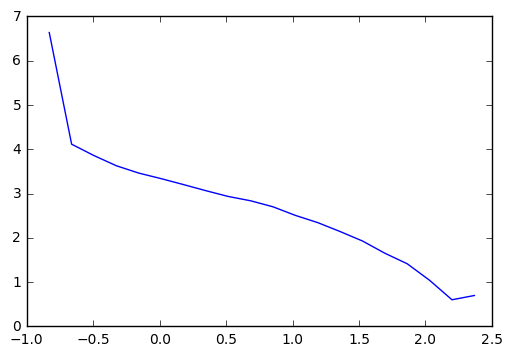

In [8]:
vals, edges = histogram(log10(subhalo_stellar_mass+1E-1), bins=20)
plot(edges[1:], log10(vals))

In [9]:
#selects the indices for two sets:
# 1. MW like 
# 2. massive galaxies above 1.5E11 Msun in stars
# 3. MW like + massive galaxies above 1.5E11 Msun in stars

index_S1 = where((subhalo_stellar_mass/hubble>1.0) & (subhalo_stellar_mass/hubble<15.0))
index_S2 = where(subhalo_stellar_mass/hubble>15.0)
index_S3 = where(subhalo_stellar_mass/hubble>1.0)
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 6419 halos
size set S2: 528 halos
size set S3: 6947 halos


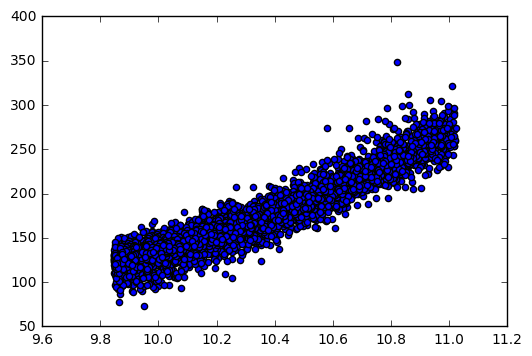

In [10]:
scatter(log10(subhalo_stellar_mass[index_S1])+10, subhalo_vmax[index_S1])

In [11]:
S3_pos = subhalos['SubhaloPos'][index_S3]
S3_vel = subhalos['SubhaloVel'][index_S3]
S3_vmax = subhalos['SubhaloVmax'][index_S3]
S3_stellar_mass = subhalo_stellar_mass[index_S3]
#https://github.com/forero/IllustrisLG/blob/master/code/LocalGroupSubVolumes.ipynb

In [12]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_vmax = S3_vmax.copy()
S3_pad_stellar_mass = S3_stellar_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_vmax = append(S3_pad_vmax, S3_vmax)
                S3_pad_stellar_mass = append(S3_pad_stellar_mass, S3_stellar_mass)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [13]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print(S3_pad_pos.shape)
print(dist_S3.shape)

(187569, 3)
(187569, 20)


In [14]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print(shape(neighbor_list))

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_stellar_mass[i]/hubble<15.0) & (S3_stellar_mass[j]/hubble<15.0)): #second check on the masses of the two galaxies
            if((dist_S3[i,1]/hubble<(1500.0)) & (dist_S3[i,1]/hubble>500.0)): #third check on the distance between the two galaxies
                stellar_mass_i = S3_pad_stellar_mass[i]
                stellar_mass_j = S3_pad_stellar_mass[j]
                star_mass_limit = min([stellar_mass_i, stellar_mass_j])
                massive_close_to_i = any((dist_S3[other_j,2:]/hubble<(2000.0)) & (S3_pad_stellar_mass[other_j]/hubble>=star_mass_limit))
                massive_close_to_j = any((dist_S3[other_l,2:]/hubble<(2000.0)) & (S3_pad_stellar_mass[other_l]/hubble>=star_mass_limit))
                if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive galaxies
                    n_pairs = n_pairs+ 1
                    halo_A_id = append(halo_A_id, int(i))
                    halo_B_id = append(halo_B_id, int(j))
print(n_pairs)


(187569, 18)
19


In [15]:
print(dist_S3[halo_A_id,1])
print(neighbor_index[halo_A_id])
print(n_S3)

[  570.25508431   555.3543255    830.16045705   903.84240178   412.1207223
   906.49344398   974.1696834    703.81988203   837.31543666  1019.75325948
   403.06357752   377.46076836   509.55161824   988.2524972    440.20238744
   935.71769741   671.96014951   883.3001936    660.62166842]
[2407 2482 5751 3929 2688 3611 3704 3607 3610 4315 4806 3440 3455 6447 4571
 5507 4947 6151 6344]
6947


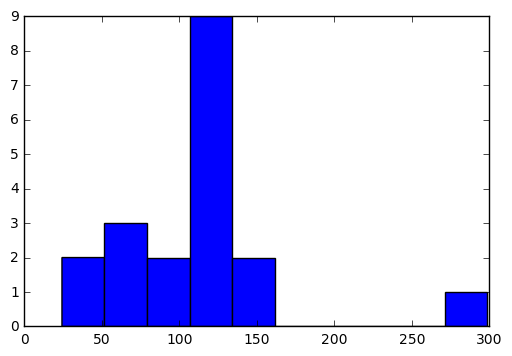

In [16]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))
a = hist(norm_relative_vel)

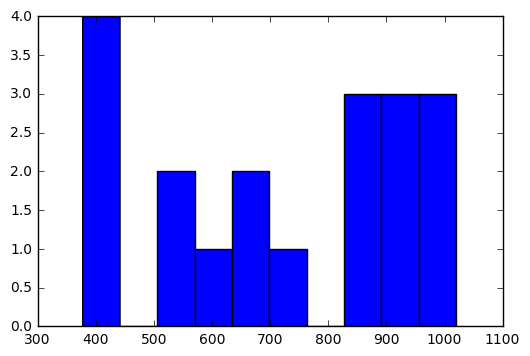

In [17]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))
a = hist(norm_relative_pos)

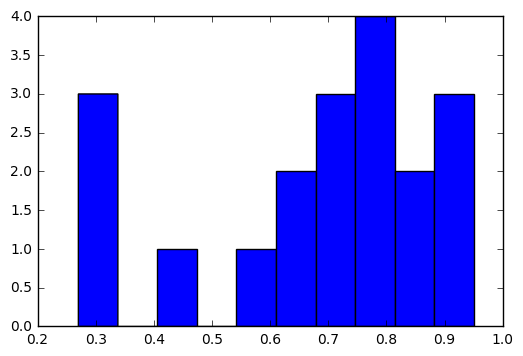

In [18]:
mass_ratio = S3_pad_stellar_mass[halo_A_id]/S3_pad_stellar_mass[neighbor_index[halo_A_id]]
index = where(mass_ratio>1.0)
mass_ratio[index] = 1.0/mass_ratio[index]
a = hist(mass_ratio)

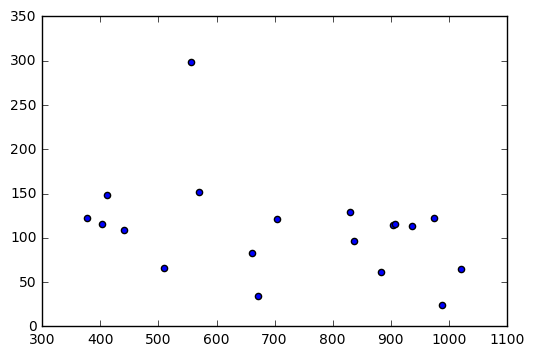

In [19]:
scatter(norm_relative_pos, norm_relative_vel)

# Sub-volume selection

In [65]:
geometric_center = 0.5*(S3_pad_pos[halo_A_id,:] + S3_pad_pos[neighbor_index[halo_A_id],:])

In [69]:
def dump_subvolume(sh, id_list, offset, boxsize, file_id=1, base_filename="test", out_dir="../data/"):
    filename = "%s/%s_%d.dat"%(out_dir, base_filename, file_id)
    out =  open(filename, "w")
    n_points = size(id_list)
    tmp_pos = subhalos['SubhaloPos']
    tmp_mags = subhalos['SubhaloStellarPhotometrics']
    tmp_vel = subhalos['SubhaloVel']
    tmp_vmax = subhalos['SubhaloVmax']
    tmp_group_number = subhalos['SubhaloGrNr']
    tmp_subhalo_masses = subhalos['SubhaloMassType']
    tmp_subhalo_stellar_mass = tmp_subhalo_masses[:,4]
    out.write("#subID\t subGroupNr x\t y\t z\t vx\t yv\t yz\t vmax\t B_MAG V_MAG M_star\n")
    out.write("#subID\t groupID\t kpc/h\t kpc/h\t kpc/h\t km/s\t km/s\t km/s\t km/s\t mags mags 10^10Msun/h\n")
    for i in range(n_points):
        ii = id_list[i]
        out.write("%d %d %f %f %f %f %f %f %f %e %e %f\n"%(ii, tmp_group_number[ii],
                                                    tmp_pos[ii,0], tmp_pos[ii,1], tmp_pos[ii,2], 
                                                       tmp_vel[ii,0], tmp_vel[ii,1], tmp_vel[ii,2],
                                                       tmp_vmax[ii], subhalo_mags[ii,1], subhalo_mags[ii,2],
                                                       tmp_subhalo_stellar_mass[ii]))

In [70]:
n_subs = size(subhalo_vmax)
print(n_subs)
for i in range(n_pairs):
    center = geometric_center[i,:]%BoxSize
   
    delta = subhalo_pos.copy()
    delta[:,0] = (delta[:,0] - center[0] + BoxSize/2.0)
    delta[:,1] = (delta[:,1] - center[1] + BoxSize/2.0)
    delta[:,2] = (delta[:,2] - center[2] + BoxSize/2.0)
    delta = delta%BoxSize
    
    norm_delta = sqrt(((delta - BoxSize/2.0)**2).sum(1))
    inside = where(norm_delta/hubble<2000.0)
    inside = inside[0]
    dump_subvolume(subhalos, inside, (center-BoxSize/2.0), BoxSize, file_id=i, base_filename="Illustris_group", out_dir="../data/mstar_selected/")
    print(size(inside))

4366546
689
864
623
729
416
471
685
868
424
680
261
231
337
269
287
687
719
308
270


In [71]:
for i in arange(n_pairs):
    data = loadtxt("../data/mstar_selected/Illustris_group_%d.dat"%(i))
    vmax = data[:,8]
    sorted_v_id = argsort(vmax)
    host_id = data[:,1]
    hosts_pair = host_id[sorted_v_id[-3:]]
    if hosts_pair[-1]==hosts_pair[-2]:
        print(i, vmax[sorted_v_id[-3:]], hosts_pair)
    

0 [ 113.438026  183.514603  266.9198  ] [ 457.  457.  457.]
1 [ 152.09053   200.123947  233.637619] [ 3808.   501.   501.]
4 [  82.811043  212.02388   220.957367] [ 624.  624.  624.]
11 [  70.238716  167.142242  187.629517] [ 29225.   1225.   1225.]
12 [  84.661621  131.85585   163.994919] [ 15127.   1238.   1238.]


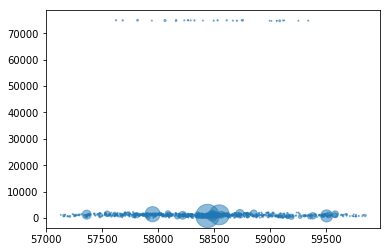

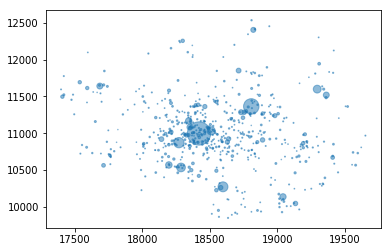

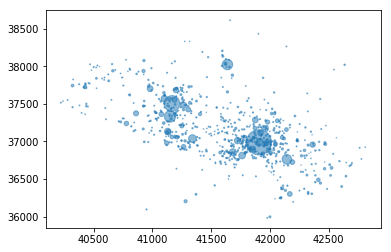

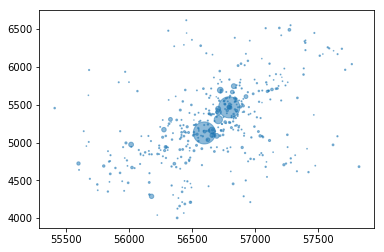

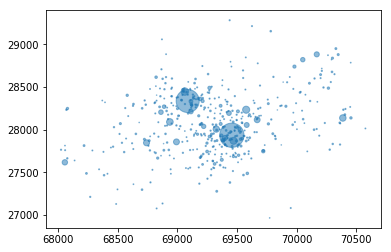

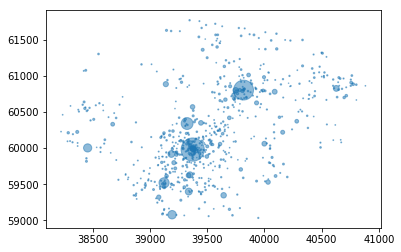

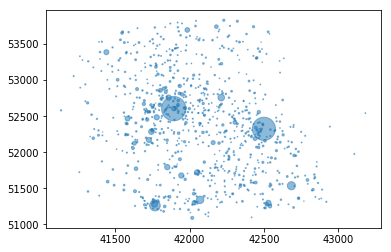

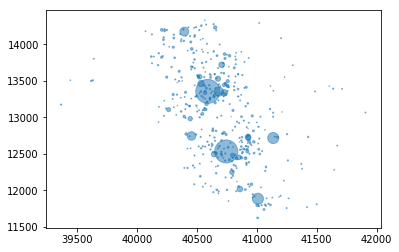

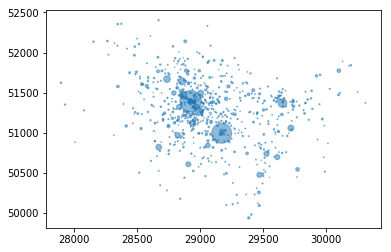

In [72]:
for i in range(1,10):
    clf()
    data = loadtxt("../data/mstar_selected/Illustris_group_{}.dat".format(i))
    scatter(data[:,2], data[:,4], s=data[:,8]**2/100, alpha=0.5)
    show()